In [5]:
from mcap_processing import open_files_in_folder, merge_dictionaries, convert_dict_to_pandas_df, get_start_end_times, get_all_msgs_from_mcap, get_important_data_for_times
from functools import reduce

In [6]:
mcap_readers, files = open_files_in_folder("./mcap_analysis/mcaps/raw")

msgs_total = {}
for reader in mcap_readers:
    msgs_total = merge_dictionaries(msgs_total, get_all_msgs_from_mcap(reader))
df = convert_dict_to_pandas_df(msgs_total)
important_times = get_start_end_times(df, "mcu_status_data", "ecu_state", "5")
cut_df = get_important_data_for_times(df, important_times)

/home/ben/mcap_analysis/mcaps/raw/07_31_2023_10_37_12.mcap


/home/ben/mcap_analysis/mcap_processing.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[topic_attr_name] = msgs['proto_msg'].apply(lambda x: getattr(x, topic_attr_name))


/tmp/ipykernel_303201/2664753916.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
/tmp/ipykernel_303201/2664753916.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))


<Figure size 2400x1200 with 0 Axes>

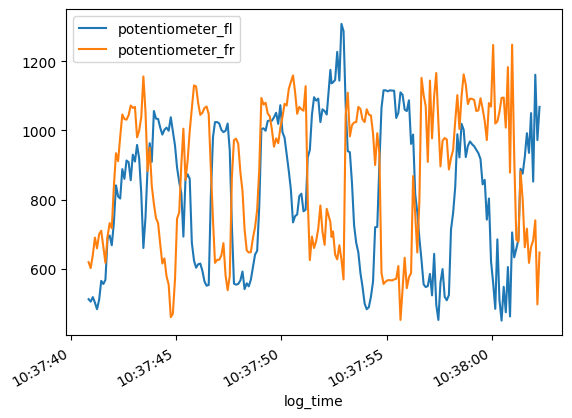

['log_time_mcu_suspension_data', 'log_time_sab_suspension_data']
[NaT Timestamp('2023-07-31 10:37:40.767498624')]
[NaT Timestamp('2023-07-31 10:37:40.787915735')]
[NaT Timestamp('2023-07-31 10:37:40.807550050')]
[NaT Timestamp('2023-07-31 10:37:40.828531420')]
[NaT Timestamp('2023-07-31 10:37:40.848212809')]
[NaT Timestamp('2023-07-31 10:37:40.869192846')]
[NaT Timestamp('2023-07-31 10:37:40.888503105')]
[NaT Timestamp('2023-07-31 10:37:40.908775402')]
[NaT Timestamp('2023-07-31 10:37:40.927711402')]
[NaT Timestamp('2023-07-31 10:37:40.948476272')]
[NaT Timestamp('2023-07-31 10:37:40.968012939')]
[NaT Timestamp('2023-07-31 10:37:40.987526883')]
[NaT Timestamp('2023-07-31 10:37:41.007218790')]
[NaT Timestamp('2023-07-31 10:37:41.026219716')]
[NaT Timestamp('2023-07-31 10:37:41.048199679')]
[NaT Timestamp('2023-07-31 10:37:41.069092105')]
[NaT Timestamp('2023-07-31 10:37:41.086215864')]
[NaT Timestamp('2023-07-31 10:37:41.107484013')]
[NaT Timestamp('2023-07-31 10:37:41.127150494')]
[NaT

<Figure size 2400x1200 with 0 Axes>

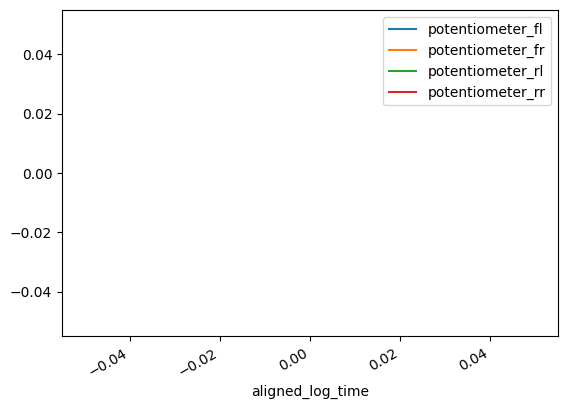

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def time_plot_msg_member(df, topic, pb_msg_member):
    msgs = df[df['topic'] == topic]
    msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_member)
    plt.show()

def time_plot_multi_msg_members(df, topic, pb_msg_members_list):
    msgs = df[df['topic'] == topic]
    plt.figure(figsize=(16, 8), dpi=150) 
    for pb_msg_member in pb_msg_members_list:
        msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_members_list)
    plt.show()

# TODO make this work
def create_aligned_data(df):
    threshold = 200
    timestamp_cols = [col for col in df.columns if 'log_time' in col]

    def timestamps_aligned(row, threshold):
        timestamps = row[timestamp_cols].values

        # TODO get the timestamp column with the least values. in this timestamp column, get the closest timestamp value in other column within some threshold.
        # TODO create a new dataframe with only these aligned rows
        

def multi_topic_time_plot_multi_msg_members(df, topic_msg_member_list_dict):
    member_list = []
    msgs_to_plot = {}
    for key, value in topic_msg_member_list_dict.items():
        member_list.extend(value)
        msgs = df[df['topic'] == key]
        for pb_msg_member in value:
            msgs_to_plot[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
            msgs_to_plot['log_time_'+key] = msgs['log_time']
    plt.figure(figsize=(16, 8), dpi=150)
    
    msgs_test = pd.DataFrame.from_dict(msgs_to_plot)
    final_df = create_aligned_data(msgs_test)
    final_df.plot(x='aligned_log_time', y=member_list)
    print(final_df)
    plt.show()
    
def analyze_sus_pots(msgs_df):
    rear_sus_pot_data = msgs_df[msgs_df['topic'] == 'sab_suspension_data']
    front_sus_pot_data = msgs_df[msgs_df['topic'] == 'mcu_suspension_data']
    pedals_data = msgs_df[msgs_df['topic']=='mcu_pedal_readings_data']
    # time_plot_msg_member(msgs_df, 'mcu_suspension_data', 'potentiometer_fr')
    time_plot_multi_msg_members(msgs_df, 'mcu_suspension_data', ['potentiometer_fl', 'potentiometer_fr'])
    msgs_dict = {
        "mcu_suspension_data": ['potentiometer_fl', 'potentiometer_fr'],
        "sab_suspension_data": ['potentiometer_rl', 'potentiometer_rr']
    }
    multi_topic_time_plot_multi_msg_members(msgs_df, msgs_dict)
    

pd.set_option('float_format', '{:f}'.format)
# print( (((cut_df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9))
cut_df = get_time_range_df(cut_df, 1690799860.758517791, 1690799882.258077093)
analyze_sus_pots(cut_df)


In [26]:
def get_time_range_df(df, start_time_epoch_sec, end_time_epoch_sec):
    return df[(((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) >= start_time_epoch_sec) & ((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) <= end_time_epoch_sec))]
